In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib
import pandas as pd
import matplotlib.pyplot as plt

from IPython.core.display import HTML

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None) 
pd.set_option('display.max_rows',None)


matplotlib.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10, 7)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-xpb9jpvs because the default path (/home/mcastro/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


*Click Hero image to reveal code cells...*

In [2]:
display(HTML("""
<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<center> <input type="image" width="100%" height="100%" alt="Click to toggle on/off the raw code" src='https://raw.githubusercontent.com/AstroMC98/Credit-Card-Fraud-Detection/main/hero.png' border="0"> </center>
</form>"""))

<div><span style="background-color: #47535c; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFFFF; font-size: 25px; font-weight: bold">1. INTRODUCTION </span></div>

In the era of online transactions and the rapid rise of E-commerce, the need for rapid detection systems for credit card fraud detection is clearly evident. Through the use of phishing emails and fraudulent calls, scammers and malicious people may be able to access and retrieve credit card information and use them for transactions in which credit card owners may or may not be aware of. Due to the rapid development and focus on ease-of-use in online payments, mitigating these fraudulent transactions without causing inconveniences for card owners has been an ideal in which analysts strive for. Due to the current limitations of tech, there are only a handful of early detection methods that can satisfy these needs up to a certain degree. One such method is through outlier analysis or anomaly detection which examines the patterns of historical transactions of each card holder and identify any abnormalities that may seem out of place or outside the normal bounds of the user's typical behaviour. Through identifying these irregularities, banks may intervene with the other party in a transaction and warn them of the concerning behaviour - whereas, in some cases, they automatically stop the transaction after the request to pay is made. In this study, we hope to investigate the use of Outlier Detection algorithms such as `Local Outlier Factor`, `Isolation Trees`, `One-Class SVM`, and `DBSCAN` to detect frauds from a dataset of credit card transactions. Note that for the purpose of this study, we will only limit our analysis to a sample of the dataset retrieved from the original dataset as to account for the memory limitations and runtimes.

<div><span style="background-color: #47535c; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFFFF; font-size: 25px; font-weight: bold">2. HIGHLIGHTS</span></div>

* Metrics matter for identifying the best algorithm in outlier detection.
* Unlike classification algorithms, outlier detection algorithms learns the inherent properties of a dataset such as distribution to identify outliers without knowledge of the target results.
* There is a trade-off between identifying more fraudulent transactions at a lower accuracy versus fewer detected fraudulent transactions at a higher accuracy.

<div><span style="background-color: #47535c; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFFFF; font-size: 25px; font-weight: bold">3. EXPLORATORY DATA ANALYSIS </span></div>

For the purpose of this paper, we limit the tasked credit card transaction dataset to its first 25,000 rows. The dataset is then split into the training features and target variable. Considering that the dataset contains mostly PCA-generated features, we retain all V_ columns to feed into our outlier detection algorithms.

In [3]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv('/mnt/data/public/creditcard/creditcard.csv', nrows =25_000)
X = df[df.columns.difference(['Class'])]
target = df['Class']
display(X.head())

,Amount,Time,V1,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V2,V20,V21,V22,V23,V24,V25,V26,V27,V28,V3,V4,V5,V6,V7,V8,V9
0,149.62,0,-1.359807,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,-0.072781,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787
1,2.69,0,1.191857,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,0.266151,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425
2,378.66,1,-1.358354,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,-1.340163,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654
3,123.50,1,-0.966272,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.185226,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024
4,69.99,2,-1.158233,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.877737,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739


We utilize the built-in method `describe()` of pandas DataFrames to generate a high-level overview of our data. All PCA'd columns (`V_ columns`), are scaled similarly in contrast to the columns `Amount` and `Time`. Through experimentation, we saw that the column `Time` resulted in poorer results for some algorithms. As such we opted to restrict this report to our results for input data without the `Time` column.

In [5]:
X = X[X.columns.difference(['Time'])]
display(X.describe())

,Amount,V1,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V2,V20,V21,V22,V23,V24,V25,V26,V27,V28,V3,V4,V5,V6,V7,V8,V9
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,75.553030,-0.235304,-0.155696,0.577609,-0.834719,0.502156,0.424476,0.020743,-0.001274,0.237844,-0.061341,-0.051331,0.180861,0.042388,-0.039173,-0.133887,-0.039028,0.011158,0.129615,0.026043,0.012949,0.005322,0.724788,0.239871,-0.191895,0.083067,-0.128825,0.025175,0.468685
std,218.143788,1.892397,1.191071,1.173146,1.530353,1.198134,1.273313,0.966904,0.948178,1.165251,0.853383,0.815432,1.552683,0.657693,0.824852,0.643300,0.531151,0.590048,0.436317,0.518278,0.397226,0.267877,1.703663,1.438492,1.440784,1.324600,1.325337,1.358029,1.270288
min,0.000000,-30.552380,-14.166795,-2.903100,-17.769143,-3.588761,-19.214325,-4.152532,-12.227189,-18.587366,-8.061208,-4.932733,-40.978852,-13.694584,-20.262054,-8.593642,-26.751119,-2.836627,-7.495741,-1.338556,-8.567638,-9.617915,-31.103685,-5.172595,-42.147898,-23.496714,-26.548144,-41.484823,-7.175097
25%,6.000000,-0.958545,-0.629095,-0.250500,-2.023532,-0.335693,-0.156991,-0.536562,-0.485517,-0.266980,-0.527577,-0.538930,-0.390169,-0.158370,-0.251599,-0.556673,-0.175394,-0.326231,-0.133674,-0.336912,-0.066041,-0.009191,0.282222,-0.667705,-0.773864,-0.661107,-0.594556,-0.165916,-0.355395
50%,18.960000,-0.280653,-0.208909,0.561350,-0.495207,0.448277,0.394858,0.147657,0.062786,0.194296,-0.038567,-0.052345,0.185411,-0.025518,-0.101237,-0.107746,-0.049744,0.062777,0.165827,-0.047788,0.006530,0.020070,0.868834,0.213589,-0.220822,-0.177213,-0.064154,0.028684,0.382077
75%,67.685000,1.164524,0.282702,1.342065,0.331297,1.381851,1.260837,0.702643,0.554103,0.698303,0.436571,0.457257,0.829745,0.157912,0.070119,0.275970,0.073934,0.399689,0.409920,0.309926,0.093624,0.077301,1.497050,1.117094,0.324782,0.472846,0.450281,0.287803,1.227177
max,7879.420000,1.960497,12.701539,12.018913,4.846452,4.465413,7.692209,3.635042,6.098529,9.253526,4.295648,4.555359,16.713389,17.281859,22.614889,5.805795,13.876221,3.695503,5.525093,3.517346,11.135740,4.860769,4.101716,13.143668,34.099309,22.529298,36.677268,20.007208,10.392889


We then investigate the underlying distribution of fraudulent and genuine transactions within our dataset. As seen from the value generated by `collections.Counter`, the genuine transactions make up ~99.6% of our total transactions where only ~0.4% of our dataset is fraudulent. Although this may seem like an issue for classical classification algorithms, as our algorithms are capable of identifying outliers through the underlying distribution or density of our data, there is no need to use resampling techniques such as `SMOTE` and `SMOTEEN`. As we will see later on in this report, even without resampling techniques, outlier detection algorithms are able to identify these outliers quite accurately.

In [6]:
from collections import Counter
counts = Counter(target)
display(counts)

Counter({0: 24912, 1: 88})

To have a better view of the distributions of each feature, we generate their corresponding histograms. As we can see below, features are not uniformly distributed whereas they have more semblance to a normal distribution where a central (mean) value bin contains the most number of points in contrast to other bins. We can also see from the histograms that some values are rare or less frequent where we can hypothesized that these are probable candidates for intervention in regards to fraudulent transactions. In the next section, we utilize various Outlier detection algorithms to identify these probable fraudulent transactions. 

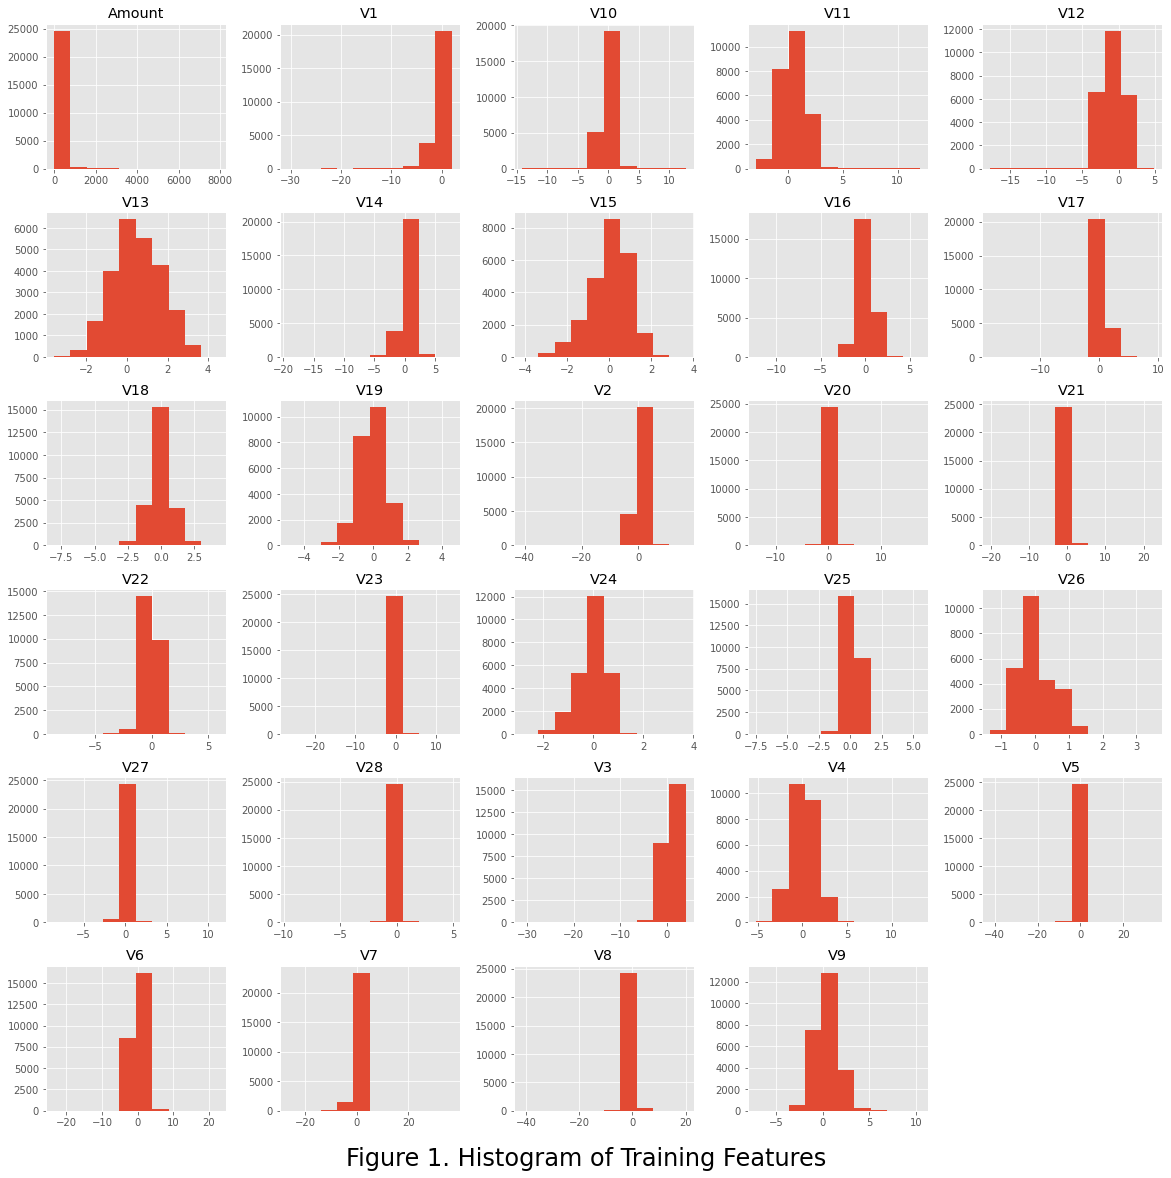

In [7]:
X.hist(figsize=(20,20))
plt.suptitle('Figure 1. Histogram of Training Features',
             y = 0.1,
             fontsize = 24)
plt.show()

<div><span style="background-color: #47535c; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFFFF; font-size: 25px; font-weight: bold">4. RESULTS AND DISCUSSION</span></div>

In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score

For the purpose of this paper, we look at the varying metrics that we can derive from the predictions of our algorithms. Aside from accuracy score, we also look at metrics such as `recall` and `precision` to measure the performance of each algorithm. `Recall` in the context in this paper, measures the ability of our algorithms to identify all fraudulent transactions in our dataset. In contrast, `Precision` measures the ability of our algorithms to identify fraudulent transactions with limited falsely identified transactions (False Positives). Since it would be more costly for banks and users to allow fraudulent claims through (False Negatives), `Recall` would be our primary metric to measure the performance of our algorithms. Parameters used for each model was determined through multiple experimentations but only the best performing models are mentioned in this paper.

<div><span style="background-color: #FFFFFF; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 10px; color: #47535c; font-size: 15px; font-weight: bold">4.1.1 Local Outlier Factor</span></div>

The Local Outlier Factor is based on the idea of quantifying the local density of the K-nearest neighbors of a point. Whereas, by comparing the invidual local densities of each point with the local densities of its K-neighbors, we can identify regions of similar density. Through this idea, data points with a comparatively lower density than its neighbors are identified as outliers. The benefit of using this algorithm is that it is able to adjust for variations and is robust enough to account for varying local densities. 

In [9]:
from sklearn.neighbors import LocalOutlierFactor

In [10]:
model = LocalOutlierFactor(n_neighbors = int(0.005*len(X)))
model.fit(X)
y_pred_411 = model.fit_predict(X)
y_pred_411[y_pred_411 == 1] = 0
y_pred_411[y_pred_411 == -1] = 1

cmat = confusion_matrix(target,y_pred_411)
tn, fp, fn, tp = cmat.ravel()
recall = (tp)/(tp+fn)
prec = (tp)/(tp+fp)
display(model)
print(f'Recall Score : {recall}')
print(f'Precision Score : {prec}')
print(f'Accuracy Score : {accuracy_score(target, y_pred_411)}')
print('Estimated number of noise points: %d' % len(y_pred_411[y_pred_411 == 1]))

LocalOutlierFactor(n_neighbors=125)

Recall Score : 0.8522727272727273
Precision Score : 0.0591016548463357
Accuracy Score : 0.95172
Estimated number of noise points: 1269


<div><span style="background-color: #FFFFFF; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 10px; color: #47535c; font-size: 15px; font-weight: bold">4.1.2 Isolation Forest</span></div>

Isolation Forest, on the other hand, is an ensemble combination of a set of isolation trees. This method performs similarly to decision trees whereas it recursively partitions our data (parallel to our axis) until these points are isolated into leaves with fewer members or instances. Shorter branches would indicate that points within a particular region would indicate less deep trees due to the sparsity of information in these locations. These shorter branches are what we tag as outliers. However, similar to Random Forest Algorithms, the results of multiple isolation trees are averaged to form the isolation forest that has a smaller variance in contrast to isolation trees. 

In [11]:
from sklearn.ensemble import IsolationForest

In [12]:
model = IsolationForest(n_estimators=500,
                        max_samples = len(X),
                        contamination='auto',
                        random_state=0)
model.fit(X)
y_pred_412 = model.fit_predict(X)
y_pred_412[y_pred_412 == 1] = 0
y_pred_412[y_pred_412 == -1] = 1

cmat = confusion_matrix(target,y_pred_412)
tn, fp, fn, tp = cmat.ravel()
recall = (tp)/(tp+fn)
prec = (tp)/(tp+fp)
display(model)
print(f'Recall Score : {recall}')
print(f'Precision Score : {prec}')
print(f'Accuracy Score : {accuracy_score(target, y_pred_412)}')
print('Estimated number of noise points: %d' % len(y_pred_412[y_pred_412 == 1]))

IsolationForest(max_samples=25000, n_estimators=500, random_state=0)

Recall Score : 0.7045454545454546
Precision Score : 0.31155778894472363
Accuracy Score : 0.99348
Estimated number of noise points: 199


<div><span style="background-color: #FFFFFF; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 10px; color: #47535c; font-size: 15px; font-weight: bold">4.1.3 One-Class SVM</span></div>

One-Class SVMs are actually not design for outlier detection but for novelty detection where the goal is to detect rare events or events that rarely occur. One-Class SVMs inherit the property of typical binary and multi-class SVMs where it classifies points by determining hyperplanes or hyperspheres that splits the data plane into n-classes. One-Class SVMs differ in the sense that as there is only one class we have to identify, we add an additional goal of maximizing the distance of novelties (or outliers in this case) from the hyperplane or hypersphere. This results to a function that identifies highly dense locations as spaces where genuine transactions lie while less dense spaces are regions where we can find novelties or fraudulent transactions.

In [13]:
from sklearn import svm
model = svm.OneClassSVM(nu=0.1, kernel='rbf') # nu is 1/C
model.fit(X)

# prediction of outliers is based on contamination level
y_pred_413 = model.fit_predict(X)
y_pred_413[y_pred_413 == 1] = 0
y_pred_413[y_pred_413 == -1] = 1

cmat = confusion_matrix(target,y_pred_413)
tn, fp, fn, tp = cmat.ravel()
recall = (tp)/(tp+fn)
prec = (tp)/(tp+fp)
display(model)
print(f'Recall Score : {recall}')
print(f'Precision Score : {prec}')
print(f'Accuracy Score : {accuracy_score(target, y_pred_413)}')
print('Estimated number of noise points: %d' % len(y_pred_413[y_pred_413 == 1]))

OneClassSVM(nu=0.1)

Recall Score : 0.7727272727272727
Precision Score : 0.02723267921505807
Accuracy Score : 0.90204
Estimated number of noise points: 2497


<div><span style="background-color: #FFFFFF; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 10px; color: #47535c; font-size: 15px; font-weight: bold">4.1.4 DBSCAN</span></div>

DBSCAN or Density-based Spatial Clustering of Applications of Noise is a clustering algorithm that is capable of identifying outliers that lie in a low-density region while clustering other points into dense and compact clusters. It leverages on the idea of 'reachability' that measures the distance of a point to its K-nearest neighbors. If a point is said to be far or not reachable from any of the members of a cluster, then that point is tagged as an outlier or, in our case, a fraudulent transaction.

In [14]:
import numpy as np
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [15]:
nn = NearestNeighbors(n_neighbors = 2).fit(X)
distances, indices = nn.kneighbors(X)
dist = np.sort(distances[:,1], axis = 0)

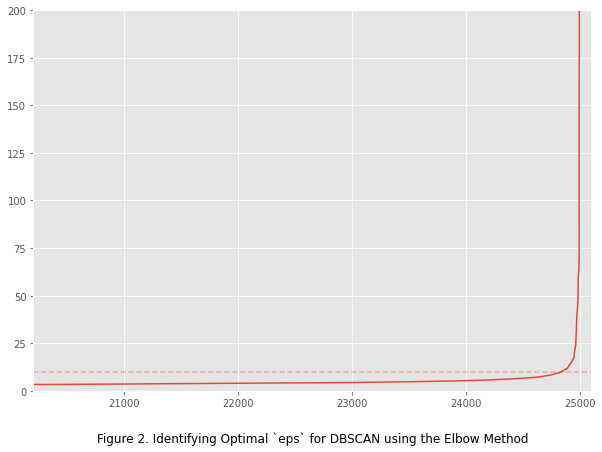

In [16]:
# Elbow Method
plt.plot(dist)
plt.axhline(y=10, color='r', linestyle='--', alpha = 0.25)
plt.xlim(20_200, 25_100)
plt.ylim(0, 200)
plt.title('Figure 2. Identifying Optimal `eps` for DBSCAN using the Elbow Method',
             y = -0.15,
             fontsize = 12)
pass

In [17]:
db = DBSCAN(eps = 10, min_samples = len(X) * 0.005).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
score = metrics.silhouette_score(X, labels)

y_pred_414 = labels.copy()
y_pred_414[y_pred_414 == -1] = 1

cmat = confusion_matrix(target,y_pred_414)
tn, fp, fn, tp = cmat.ravel()
recall = (tp)/(tp+fn)
prec = (tp)/(tp+fp)
display(model)
print(f'Recall Score : {recall}')
print(f'Precision Score : {prec}')
print(f'Accuracy Score : {accuracy_score(target, y_pred_414)}')
print('Estimated number of noise points: %d' % n_noise_)

OneClassSVM(nu=0.1)

Recall Score : 0.8181818181818182
Precision Score : 0.04114285714285714
Accuracy Score : 0.93224
Estimated number of noise points: 1750


In [18]:
labels = ['Isolation Forest', 'LOF', 'DBSCAN', 'One-Class SVM']
preds = [y_pred_412, y_pred_411, y_pred_414, y_pred_413]
n_outliers = [sum([1 for i in zip(p, target) if sum(i) == 2]) for p in preds]
FN = [sum([1 for i in zip(p,target) if i == (0, 1)]) for p in preds]
FP = [sum([1 for i in zip(p,target) if i == (1, 0)]) for p in preds]

<div><span style="background-color: #FFFFFF; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 10px; color: #47535c; font-size: 20px; font-weight: bold">4.2 Visualizing Results of Outlier Detection Algorithms</span></div>

Shown below is a visualization detailing the results of our outlier detection algorithms. It represents the number of fraudulent and non-fraudulent transactions identified within our dataset for each algorithm used. It contains two subplots, the first subplot details the transactions that were identified as fraudulent by our algorithms. It also specifies the total number of points that are actually fraudulent (True Positives) and points that were identified as fraudulent but actually genuine (False Positives). The other subplot details the total number of transactions that are actually fraudulent but identified as genuine (False Negatives). 

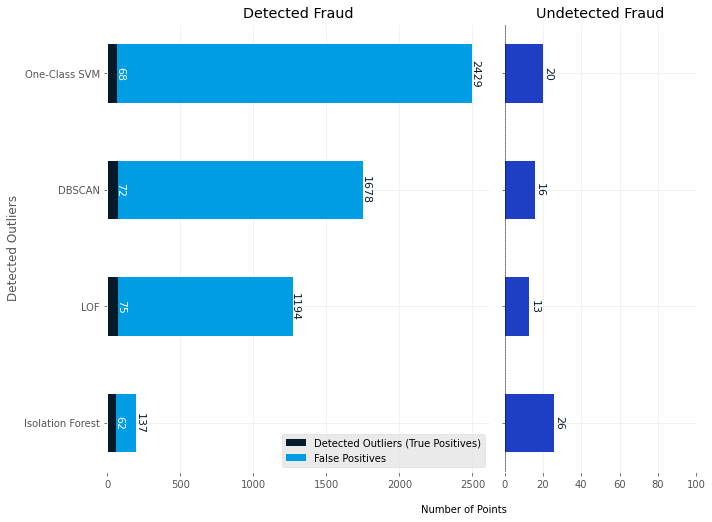

In [19]:
import matplotlib as mpl
from matplotlib.patches import Patch

mpl.rcParams['hatch.linewidth'] = 1.5 

legend_elements = [Patch(facecolor='red', label='Outliers'),
                   Patch(facecolor='blue', label='False Positives'),
                   Patch(facecolor='gray', label='False Negatives')]
width = 0.5 

fig, (ax1, ax2) = plt.subplots(1,2,
                               sharey = True,
                               gridspec_kw={'width_ratios': [2, 1]})

ax1.barh(labels, n_outliers, width, label='Detected Outliers (True Positives)',
         color = '#051b2a')
ax1.barh(labels, FP, width, left = n_outliers, label = 'False Positives',
         color = '#009ce4')

k=0
for bar in ax1.patches:
    if k < 4:
        ax1.annotate(bar.get_width(),
                    (bar.get_width(),
                     bar.get_y() + bar.get_height()/2),
                     ha='center', va='center',
                     rotation = 270,
                     color = 'white',
                     size=11, xytext=(3, 0),
                     textcoords='offset points')
    else:
        ax1.annotate(bar.get_width(),
            (bar.get_width(),
             bar.get_y() + bar.get_height()/2),
             ha='center', va='center',
             rotation = 270,
             color = '#051b2a',
             size=11, xytext=(13, 0),
             textcoords='offset points')
    k+=1

ax1.set_ylabel('Detected Outliers')
ax1.set_title('Detected Fraud')
ax1.legend()

ax2.barh(labels, FN, width, label='False Negatives',
         color = '#1e3ec3',
         )
ax2.set_xlim(0,100)
ax2.set_title('Undetected Fraud')

for bar in ax2.patches:
    ax2.annotate(bar.get_width(),
        (bar.get_width(),
         bar.get_y() + bar.get_height()/2),
         ha='center', va='center',
         rotation = 270,
         color = '#051b2a',
         size=11, xytext=(5, 0),
         textcoords='offset points')

ax1.set_facecolor('white')
ax1.grid(color='gainsboro', linestyle='--', linewidth=0.5)
ax2.set_facecolor('white')
ax2.spines['left'].set_linewidth(0.5)
ax2.spines['left'].set_linestyle('--')
ax2.spines['left'].set_color('k')
ax2.grid(color='gainsboro', linestyle='--', linewidth=0.5)
fig.tight_layout()

fig.text(0.65,-0.025, 'Number of Points', ha='center')
plt.show()

From the figure above, we can see that `Isolation Forest` identified the least number of outliers (199) while also having the most number of undetected fraudulent transactions (26). In contrast, `LOF` and `DBSCAN` identified more outliers while having fewer undetected fraudulent transactions. Lastly, `One-Class SVM` identified the most outliers between our outlier detection algorithms while still having more undetected fraudulent transactions in contrast to `LOF` and `DBSCAN`.

As a general observation, all four algorithms were able to identify majority of our fraudulent transactions (True Positives), however it is clear that a significant number of genuine transactions were falsely classified as fraudulent (False Positives). With the challenge of identifying the trade-offs between having more False Positives but lower False Negatives, we can clearly see that `LOF` and `Isolation Forest` are the best outlier detection models which showcases the two extremes of our ideal fraud detection algorithm.  Whereas although `Isolation Forest` was the worse in terms of the number of undetected fraudulent transactions, it was able to do this with the least number of False Positives of 137 falsely flagged transactions. In contrast, `LOF` was able to detect the most number of fraudulent transactions with only 13 undetected fraudulent transactions. This is half the amount missed by `Isolation Forest`. However, this comes with the trade-off of falsely flagging more genuine transactions within our dataset as fraudulent. To determine which one is better generally requires subject matter expertise or more domain-specific metrics. However, one can argue that missed fraudulent transactions are more costly compared to the inconvenience of some customers for their transactions. The repercussions of having credit card user's hard-earned money loss to fraudulent transactions is greater in contrast to a few confirmatory steps required to clear up falsely flagged transactions. As such, `LOF` clearly outperforms other outlier detection algorithms in this regard. This difference can be better represented in a table format in the following section. 

<div><span style="background-color: #FFFFFF; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 10px; color: #47535c; font-size: 20px; font-weight: bold">4.3 Summary of Results</span></div>

| Algorithm Used | Precision  | Recall | Accuracy | Number of Outliers |
| :---        |    :----:   |          :---: |          :---: |          ---: |
| Isolation Forest      | 0.312 | 0.704 | 0.993 | 199 |
| Local Outlier Factor   | 0.059 | 0.852 | 0.952  | 1269 |
| DBSCAN   | 0.041  | 0.818      | 0.932  | 1750  |
| One-Class SVM   | 0.027  | 0.773      | 0.902  | 2497  |

Re-itterating our findings from the previous section, `LOF` resulted to the highest `recall` from our outlier detection algorithms. `Recall`, as mentioned earlier, prioritizes the ability of our algorithms to identify all fraudulent transactions in our dataset. So, although `Isolation Forest` has a higher `Precision` and `Accuracy`, it still pales in comparison to `LOF`'s recall.  

Looking at `DBSCAN`'s and `One-Class SVM`'s performance, although they identified more transactions as fraudulent, they did not necessarily return better results in contrast to `LOF`. This suggests that `LOF`'s inherent ability to distinguish local communities within our high-dimensional dataset improved its performance to identify these fraudulent transactions. 

<div><span style="background-color: #47535c; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFFFF; font-size: 25px; font-weight: bold">5. CONCLUSION </span></div>

From our results from Section `4.1`, Section `4.2`, and Section `4.3`, the best outlier detection algorithm with respect to Credit Card Fraud Detection is `Local Outlier Factors` which although flagged more False Positives in contrast to `Isolation Forest`, it was still able to identify the most True Positives between the other algorithms. With the trade-off of having a lower accuracy, `Local Outlier Factor` had the highest recall from among its peers. Another observation we can derive from our findings is that although algorithms such as `DBSCAN` and `One-Class SVM` tagged more transactions as fraudulent (Positives), it did not necessarily translate to more actual fraudulent transactions (True Positives) being detected. 

Through the use of algorithms such as `LOF` and `Isolation Forest` we are able to distinguish outliers or fraudulent transactions without the knowledge of the actual labels of each point. Therefore, unlike supervised classification algorithms designed for classifying on imbalanced datasets that may require resampling techniques such as `SMOTE`, outlier detection algorithms are relatively easier to implement as it requires fewer information to operate (e.g. the lack of a target class).

<div><span style="background-color: #47535c; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFFFF; font-size: 25px; font-weight: bold">6. REFERENCES </span></div>

[1] Dwivedi, A.K., Rai, A.K., Kashyap, A. (2021). Fraud Detection in Credit Card Transactions using Anomaly Detection. Turkish Journal of Computer and Mathematics Education. 12(12), 837-846. https://turcomat.org/index.php/turkbilmat/article/view/7473 